# Example application of quipcell to bulk deconvolution

In this vignette, we demonstrate the application of `quipcell` to bulk deconvolution, replicating some analyses from the manuscript.

For our dataset, we use the Human Lung Cell Atlas, which consists of several studies. We hold out one of the studies as a test set, which we use to generate (pseudo)bulk samples with known ground truth.

To make this analysis runnable on a laptop, the data has been preprocessed into a smaller form (just the raw counts of the highly variable genes). See the [vignette readme](Readme.md) for instructions on how to download or generate the preprocessed data before running this notebook.

In [1]:
from collections import Counter

import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd

import plotnine as gg
import mizani
import mizani.transforms as scales

import anndata as ad
import scanpy as sc

import scipy.sparse

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder

import quipcell as qpc

## Load single cell data

First, we load the (preprocessed) Human Lung Cell Atlas data.

In [2]:
adata = ad.read_h5ad("data/hlca_hvgs.h5ad")

Next, we subset to 1/8th of the dataset to improve speed. We also exclude one of the studies as a validation test set to benchmark bulk deconvolution.

In [3]:
validation_study = 'Krasnow_2020'

rng = np.random.default_rng(12345)
n = adata.obs.shape[0]

keep = adata.obs['study'] != validation_study
keep = keep & (rng.random(size=n) < .125)

adata_ref = adata[keep,:]
print(f"{adata_ref.shape[0]} cells in reference set")

65531 cells in reference set


/Users/kammj2/miniconda3/envs/quipcell/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


## Normalize and transform single cell data

Next, normalize the raw counts. The preprocessing script saved the total UMIs per cell before filtering to highly variable genes, so we divide it out, and normalize to counts per 1000 UMIs.

In [4]:
# Normalize
normalize_sum = 1000
adata_ref.X = scipy.sparse.diags(normalize_sum / adata_ref.obs['n_umi'].values) @ adata_ref.X

Next, we run PCA, and then perform Linear Discriminant Analysis on the PCs and celltype labels. This will be the embedding space we use for `quipcell`.

In [5]:
sc.pp.pca(adata_ref, n_comps=100)

# since the PCA is zero-centered, we need to save the gene-wise means
# to apply PCA rotation to pseudobulks
gene_means = adata_ref.X.mean(axis=0)
gene_means = np.squeeze(np.asarray(gene_means))
adata_ref.var['x_mean'] = gene_means

lda = LinearDiscriminantAnalysis(n_components=15)

X = adata_ref.obsm['X_pca']
y = adata_ref.obs['ann_finest_level']

lda.fit(X, y)

adata_ref.obsm['X_lda'] = lda.transform(adata_ref.obsm['X_pca'])

## Load and transform (pseudo)bulk data

Next, we read in the pseudobulk counts (generated in `preprocessing.py`), and subset to the samples in the validation/test set.

We then normalize the counts, and subset to the same genes as the reference single cell set.

Then, we apply a linear transformation to map the bulk samples to the embedding space.

In [6]:
adata_pseudobulk = ad.read_h5ad("data/pseudobulks.h5ad")

# Subset to validation set
keep = adata_pseudobulk.obs['study'] == validation_study
adata_pseudobulk = adata_pseudobulk[keep,:]

# Normalize on the same scale as the single cell reference set
adata_pseudobulk.raw = adata_pseudobulk
sc.pp.normalize_total(adata_pseudobulk, target_sum=normalize_sum)

# Subset to same genes as the single cell reference set
adata_pseudobulk = adata_pseudobulk[:, adata.var.index]

# Apply PCA rotation to pseudobulks
X = adata_pseudobulk.X - adata_ref.var['x_mean'].values
X = np.asarray(X @ adata_ref.varm['PCs'])
adata_pseudobulk.obsm['X_pca'] = X
# Apply LDA rotation to pseudobulks
adata_pseudobulk.obsm['X_lda'] = lda.transform(X)

/Users/kammj2/miniconda3/envs/quipcell/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


## Estimate weights for read-level abundances

Now that the single cell reference set and the bulk samples are in the same embedding space, we can estimate the weights with `quipcell`.

In [7]:
w_umi = qpc.estimate_weights_multisample(adata_ref.obsm['X_lda'],
                                         adata_pseudobulk.obsm['X_lda'])

INFO:quipcell.solvers:Solving for sample i=0
INFO:quipcell.solvers:objective=2.2005075851980926, optimal
INFO:quipcell.solvers:Solving for sample i=1
INFO:quipcell.solvers:objective=1.3962363351808462, optimal
INFO:quipcell.solvers:Solving for sample i=2
INFO:quipcell.solvers:objective=2.195289714748819, optimal
INFO:quipcell.solvers:Solving for sample i=3
INFO:quipcell.solvers:objective=1.0717276850850508, optimal
INFO:quipcell.solvers:Solving for sample i=4
INFO:quipcell.solvers:objective=0.4401993828524996, optimal


## Convert read-level abundance to cell-level abundance

Note that the gene counts of bulk samples don't normalize for the fact that different cell types have different number of reads. Therefore, the weights represent a probability distribution of a random _read_ drawn from the bulk sample, rather than a probability distribution over a random _cell_ from the bulk sample.

We can convert the read-level weights to cell-level weights by estimating size factors for each of the reference cells, and normalizing the weights by those.

If the reference set doesn't have too much technical variation, then we can just use the number of UMIs per cell as the normalizing factor. However, the HLCA is a highly heterogeneous dataset, consisting of many samples from different studies, sequenced to different depths, and containing different celltypes. Therefore, we need to control for sample when estimating the size factors. `quipcell` provides a method to estimate size factors while controlling for sample by using Poisson regression.

In [8]:
# Estimate size factors using Poisson regression
size_factors = qpc.estimate_size_factors(
    adata_ref.obsm['X_lda'],
    adata_ref.obs['n_umi'].values,
    adata_ref.obs['sample'].values,
    #verbose=True
)

# Convert read-level weights to cell-level weights
w_cell = qpc.renormalize_weights(w_umi, size_factors)

/Users/kammj2/miniconda3/envs/quipcell/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:290: RuntimeWarning: invalid value encountered in matmul
/Users/kammj2/miniconda3/envs/quipcell/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:290: RuntimeWarning: invalid value encountered in matmul


## Plot inferred weights

Below, we plot the read-level and cell-level weights on the reference UMAP for each of the 5 validation bulk samples.

/Users/kammj2/miniconda3/envs/quipcell/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


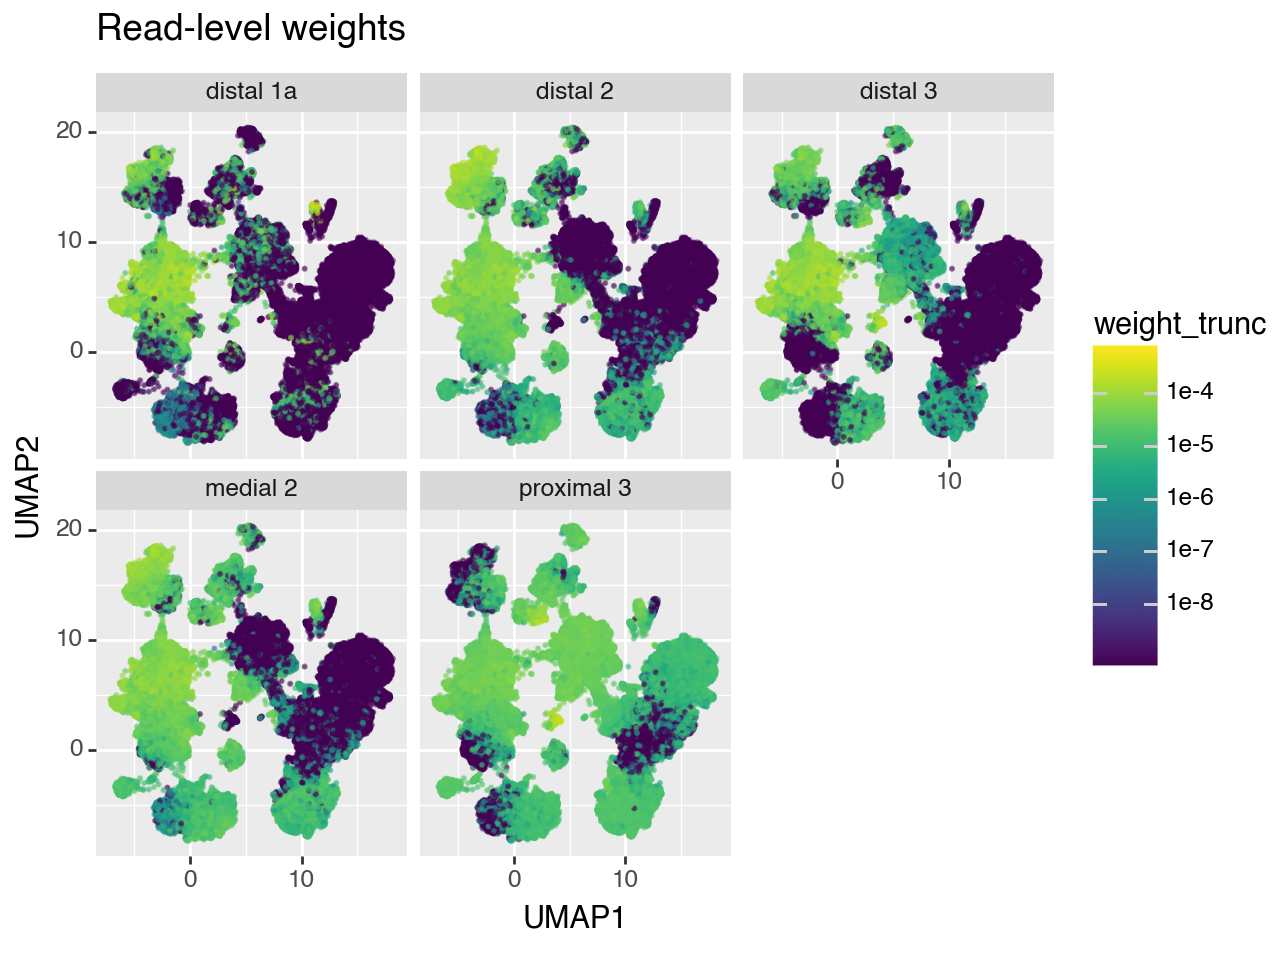

<Figure Size: (640 x 480)>

In [9]:
# Dataframe for plotting UMI-level weights on UMAP
df = pd.DataFrame(
    np.hstack([adata_ref.obsm['X_umap'], w_umi]),
    columns = ['UMAP1', 'UMAP2'] + list(adata_pseudobulk.obs.index)
).melt( # pivot to long format
    id_vars=['UMAP1', 'UMAP2'],  
    var_name='sample', 
    value_name='weight'
)

# set very small weights to 0 for prettier plotting
weight_trunc = df['weight'].values.copy()
weight_trunc[weight_trunc < 1e-9] = 0
df['weight_trunc'] = weight_trunc

(gg.ggplot(df, gg.aes(x="UMAP1", y="UMAP2", color="weight_trunc")) +
    gg.geom_point(size=.25, alpha=.5) +
    gg.facet_wrap("~sample") +
    gg.scale_color_cmap(trans=scales.log_trans(base=10)) +
    gg.ggtitle("Read-level weights"))

/Users/kammj2/miniconda3/envs/quipcell/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


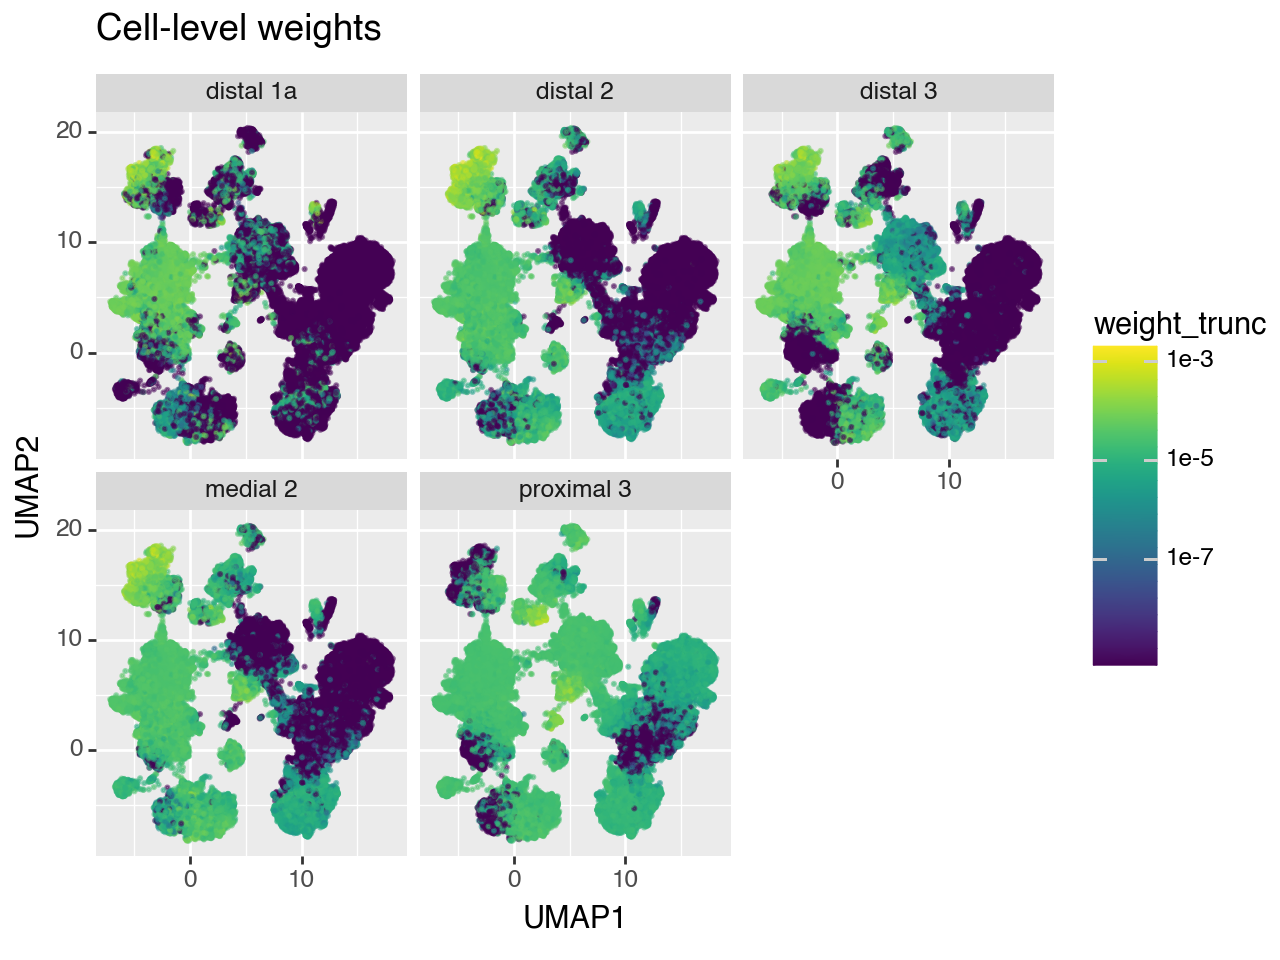

<Figure Size: (640 x 480)>

In [10]:
 # Dataframe for plotting cell-level weights on UMAP
df = pd.DataFrame(
    np.hstack([adata_ref.obsm['X_umap'], w_cell]),
    columns = ['UMAP1', 'UMAP2'] + list(adata_pseudobulk.obs.index)
).melt( # pivot to long format
    id_vars=['UMAP1', 'UMAP2'],  
    var_name='sample', 
    value_name='weight'
)

# set very small weights to 0 for prettier plotting
weight_trunc = df['weight'].values.copy()
weight_trunc[weight_trunc < 1e-9] = 0
df['weight_trunc'] = weight_trunc

(gg.ggplot(df, gg.aes(x="UMAP1", y="UMAP2", color="weight_trunc")) +
    gg.geom_point(size=.25, alpha=.5) +
    gg.facet_wrap("~sample") +
    gg.scale_color_cmap(trans=scales.log_trans(base=10)) +
    gg.ggtitle("Cell-level weights"))

## Plot true vs estimated abundances

Next, we compare the estimated weights to the true celltype proportions. In the preprocessing script, we precomputed the fraction of reads and cells coming from each celltype, at different levels of celltype annotation. We read in these precomputed abundances below.

In [11]:
df_abundance = pd.read_csv('data/abundances.csv')
# filter to samples in the validation set
df_abundance = df_abundance[df_abundance['sample'].isin(adata_pseudobulk.obs.index)]
# convert sample name to string to prevent missing categorical levels
df_abundance['sample'] = df_abundance['sample'].astype(str)
df_abundance

,sample,ann_level,celltype,n_umi,frac_umi,n_cell,frac_cell
644,distal 1a,lvl1,Endothelial,4461681,0.060048,1495,0.198724
645,distal 1a,lvl1,Epithelial,8394719,0.112981,853,0.113386
646,distal 1a,lvl1,Immune,59114660,0.795600,4719,0.627276
647,distal 1a,lvl1,Stroma,2330951,0.031371,456,0.060614
648,distal 2,lvl1,Endothelial,30078564,0.205619,8449,0.455693
...,...,...,...,...,...,...,...
25559,proximal 3,lvl5,Subpleural fibroblasts,0,0.000000,0,0.000000
25560,proximal 3,lvl5,Suprabasal,10395727,0.130773,482,0.062041
25561,proximal 3,lvl5,T cells proliferating,34048,0.000428,1,0.000129
25562,proximal 3,lvl5,Tuft,0,0.000000,0,0.000000


Next, we compute estimated celltype abundances, by summing over the weights fit by `quipcell`. We add the estimated number of reads and cells coming from each celltype to the dataframe of abundances.

In [12]:
est_frac_umi = []
est_frac_cells = []

# TODO use a more descriptive variable name than i
for i in range(1, 6):
    enc = OneHotEncoder()
    mat_onehot = enc.fit_transform(
        adata_ref.obs[f'celltype_lvl{i}'].values.reshape(-1,1)
    )

    # Function to sum weights by celltype, then pivot to long dataframe
    def aggregate_and_reshape(w):
        return pd.DataFrame(
            w.T @ mat_onehot,
            columns = enc.categories_[0],
            index = adata_pseudobulk.obs.index
        ).reset_index(names='sample').melt(
            id_vars=['sample'], var_name=['celltype'], value_name='weight'
        ).assign(ann_level=f'lvl{i}')

    est_frac_umi.append(aggregate_and_reshape(w_umi))
    est_frac_cells.append(aggregate_and_reshape(w_cell))


# Function to combine the summed weights across annotation levels,
# returning a vector to be added to df_abundance
def concat_aggregated_weights(agg_weight_list):
    idx_keys = ['ann_level', 'sample', 'celltype']
    return (pd.concat(agg_weight_list)
            .set_index(idx_keys)
            .loc[zip(*[df_abundance[k] for k in idx_keys])]
            .values)

df_abundance['est_frac_umi'] = concat_aggregated_weights(est_frac_umi)
df_abundance['est_frac_cell'] = concat_aggregated_weights(est_frac_cells)

df_abundance

,sample,ann_level,celltype,n_umi,frac_umi,n_cell,frac_cell,est_frac_umi,est_frac_cell
644,distal 1a,lvl1,Endothelial,4461681,0.060048,1495,0.198724,0.055624,0.184102
645,distal 1a,lvl1,Epithelial,8394719,0.112981,853,0.113386,0.085796,0.085770
646,distal 1a,lvl1,Immune,59114660,0.795600,4719,0.627276,0.843635,0.710124
647,distal 1a,lvl1,Stroma,2330951,0.031371,456,0.060614,0.014945,0.020004
648,distal 2,lvl1,Endothelial,30078564,0.205619,8449,0.455693,0.177143,0.379684
...,...,...,...,...,...,...,...,...,...
25559,proximal 3,lvl5,Subpleural fibroblasts,0,0.000000,0,0.000000,0.000464,0.000488
25560,proximal 3,lvl5,Suprabasal,10395727,0.130773,482,0.062041,0.036868,0.029626
25561,proximal 3,lvl5,T cells proliferating,34048,0.000428,1,0.000129,0.000636,0.001184
25562,proximal 3,lvl5,Tuft,0,0.000000,0,0.000000,0.000277,0.000255


Finally, we plot the estimated vs actual abundances, at both the read and cell level.

At the finest resolution (annotation level 5), there is some inaccuracy because a common celltype in the validation set (CCL3+ Alveolar macrophages) is very rare in the reference samples, and cannot be distinguished from other Alveolar macrophages in the embedding space. See the manuscript for more details.

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


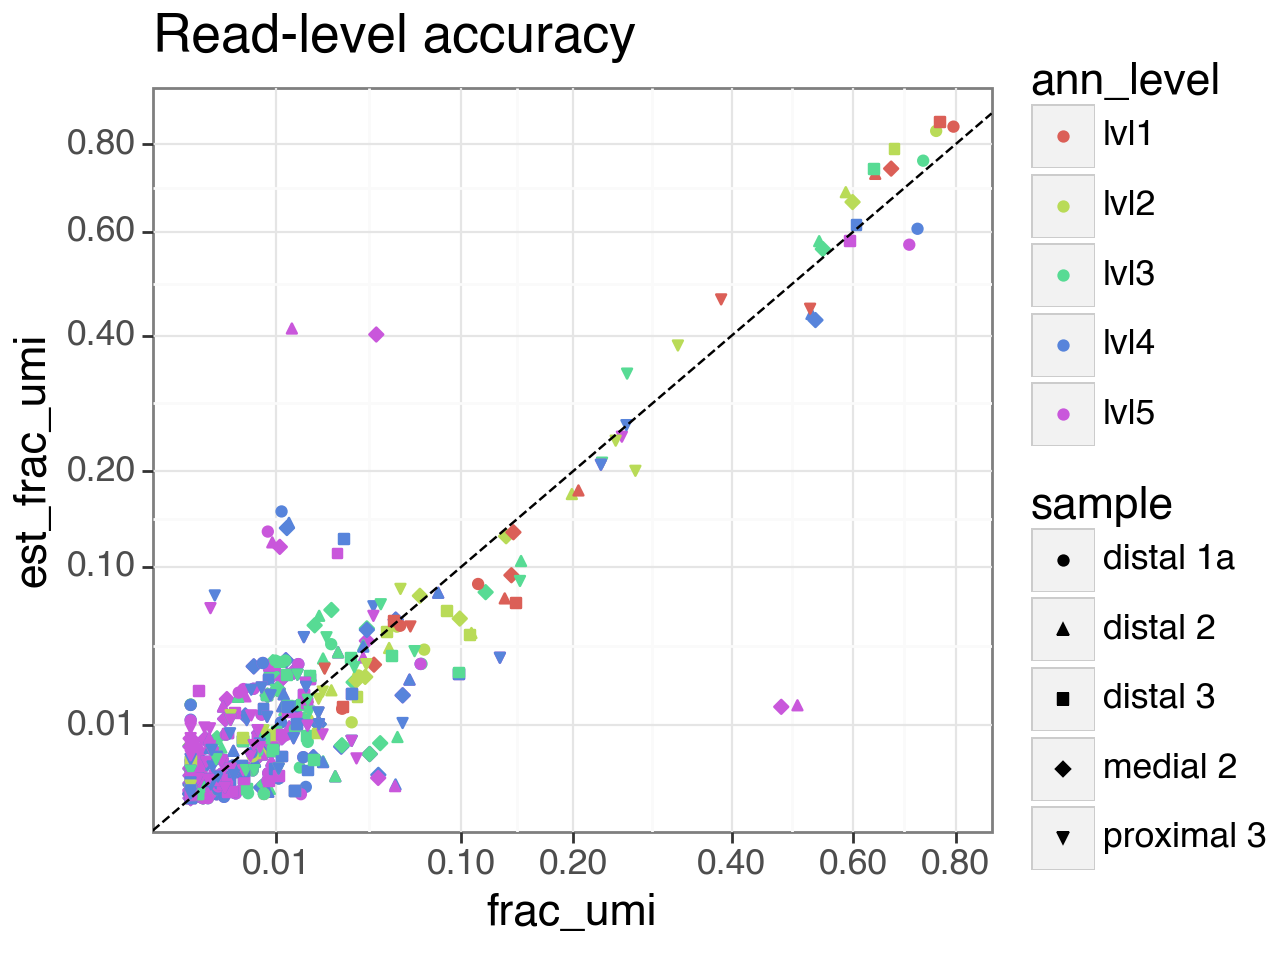

<Figure Size: (640 x 480)>

In [13]:
 (gg.ggplot(df_abundance.sample(frac=1, random_state=42), 
           gg.aes(x="frac_umi", y="est_frac_umi", color="ann_level", shape="sample")) +
    gg.geom_point() +
    gg.geom_abline(linetype='dashed') +
    gg.scale_x_sqrt(breaks=[.01,.1,.2,.4,.6,.8]) +
    gg.scale_y_sqrt(breaks=[.01,.1,.2,.4,.6,.8]) +
    gg.theme_bw(base_size=16) +
    gg.ggtitle("Read-level accuracy"))

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


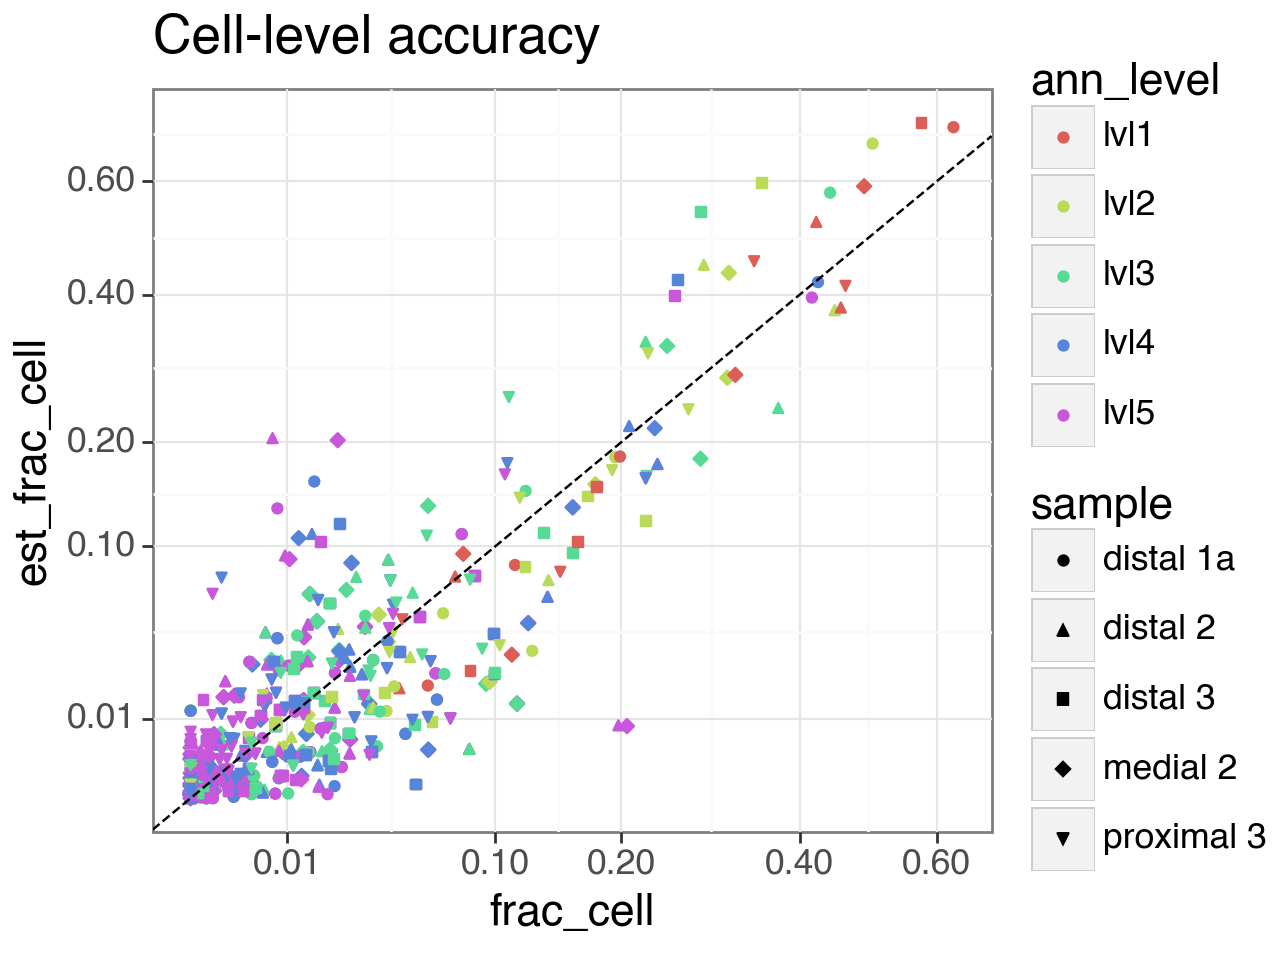

<Figure Size: (640 x 480)>

In [14]:
 (gg.ggplot(df_abundance.sample(frac=1, random_state=42), 
           gg.aes(x="frac_cell", y="est_frac_cell", color="ann_level", shape="sample")) +
    gg.geom_point() +
    gg.geom_abline(linetype='dashed') +
    gg.scale_x_sqrt(breaks=[.01,.1,.2,.4,.6,.8]) +
    gg.scale_y_sqrt(breaks=[.01,.1,.2,.4,.6,.8]) +
    gg.theme_bw(base_size=16) +
    gg.ggtitle("Cell-level accuracy"))